# Conversion of Lausanne grid data from Lu

In [1]:
# Import packages
import os
import logging
from pathlib import Path
import geopandas as gpd
import pandas as pd
from shapely.geometry import Polygon
from shapely.ops import unary_union
import matplotlib.pyplot as plt

logging.basicConfig(level=logging.INFO,
                    format='[%(levelname)s] %(funcName)s: %(message)s',
                    )

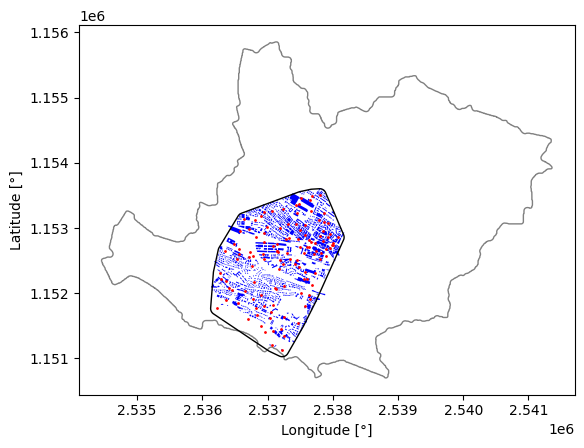

In [ ]:
shared_folder = '/Users/catarina/switchdrive/IPESE-DESL_data_exchange/SDEWES2025'
grid_path = os.path.join(shared_folder, 'sebeillon-node-loc.csv')
buildings_path = '/Users/catarina/switchdrive/IPESE-DESL_data_exchange/Weather/CRYOS_data/buildings_cryos.gpkg'

def generate_gdf(point_path, long_col, lat_col, input_crs):
    """
    Function to generate a geodataframe from a csv file with point data.
    Parameters:
    - point_path: str, path to the csv file
    - long_col: str, name of the column with the longitude data
    - lat_col: str, name of the column with the latitude data
    - crs: int, EPSG code of the coordinate reference system
    Returns:
    - gdf: geopandas geodataframe
    """
    # check if extension is csv
    if Path(point_path).suffix == '.csv':
        # read csv
        df = pd.read_csv(point_path)
        # create geometry column
        df['geometry'] = gpd.points_from_xy(df[long_col], df[lat_col])
        # create geodataframe
        gdf = gpd.GeoDataFrame(df, geometry='geometry', crs=input_crs)
        return gdf
    else:
        print('File extension not supported. Please provide a csv file.')

def generate_grid_mask(grid_gdf, offset, crs_output):
    """
    Function to generate a polygon mask from a line that encircles the points from a GeoDataFrame plus an offset.
    
    Parameters:
    - grid_gdf: geopandas GeoDataFrame, grid points
    - offset: int, buffer offset in meters
    - crs_output: int, EPSG code of the output coordinate reference system
    
    Returns:
    - mask: geopandas GeoDataFrame, polygon mask of the grid
    """
    # Create a convex hull around the points
    hull = unary_union(grid_gdf.geometry).convex_hull

    # Apply buffer (offset in meters)
    mask_polygon = hull.buffer(offset)

    # Convert back to the original CRS if needed
    mask_gdf = gpd.GeoDataFrame(geometry=[mask_polygon], crs=grid_gdf.crs)
    
    # Reproject to the specified output CRS if necessary
    if crs_output is not None and mask_gdf.crs.to_epsg() != crs_output:
        mask_gdf = mask_gdf.to_crs(epsg=crs_output)

    return mask_gdf

def clean_qbuildings(buildings_path,crs):
    """
    Checks if there are empty columns and nan values that might give errors when running reho, and removes them.
    If necessary, converts the coordinate's reference system to the one from the temperature file
    Returns:
        buildings_gdf: Cleaned buildings GeoDataFrame
    """
    
    # read buildings
    buildings_gdf = gpd.read_file(buildings_path)

    # Initial row count
    build_ini = buildings_gdf.shape[0]
    logging.info(f'reading file with {build_ini} buildings')
    #buildings_gdf.to_csv('buildings_ini.csv')

    # Check for completely empty columns
    empty_columns = buildings_gdf.columns[buildings_gdf.isna().all()].tolist()
    if empty_columns:
        buildings_gdf = buildings_gdf.drop(columns=empty_columns)
        logging.warning(f'Dropped empty columns: {empty_columns}')

    # Check for NaN values
    nan_dict = {}
    for row_index in range(len(buildings_gdf)):
        row = buildings_gdf.loc[row_index].isna() # checks each column in the specified row for NaN values
        nan_col = row[row].index.tolist()  # Get columns with NaN
        if nan_col:
            id_building = buildings_gdf['id_building'].loc[row_index]
            nan_dict[id_building] = nan_col  # Add id_building and NaN columns to dictionary

    # Drop buildings with NaN values
    # Get the list of id_building values to drop from nan_dict
    ids_to_drop = list(nan_dict.keys())
    # Drop rows where id_building is in ids_to_drop
    buildings_gdf = buildings_gdf[~buildings_gdf['id_building'].isin(ids_to_drop)]
    build_drop = build_ini - buildings_gdf.shape[0]
    logging.warning(f'{build_drop} buildings with NaN values dropped')

    # Extract the CRS
    crs_ini = buildings_gdf.crs

    if crs_ini != crs:
        buildings_gdf = buildings_gdf.to_crs(crs)
        logging.warning(f'Converted CRS from {crs_ini} to {crs}')
    else:
        logging.info(f'CRS: {crs_ini}')

    return buildings_gdf

def apply_grid_mask(buildings_gdf,grid_mask):
        """
        Function to apply a grid mask to a GeoDataFrame of buildings.
        Parameters:
            buildings_gdf: GeoDataFrame with buildings
            grid_mask: GeoDataFrame with the grid
        Returns:
            buildings_gdf: GeoDataFrame with buildings inside the grid mask
        """

        # ensure both GeoDataFrames use the same CRS
        if buildings_gdf.crs != grid_mask.crs:
            crs_ini = buildings_gdf.crs
            buildings_gdf = buildings_gdf.to_crs(grid_mask.crs)
            logging.warning(f'Converted buildings CRS from {crs_ini} to {buildings_gdf.crs}')

        # Compute centroids of the buildings
        centroids = buildings_gdf.copy()
        centroids["geometry"] = buildings_gdf.geometry.centroid

        # Perform spatial join using "within" to keep buildings whose centroids are inside the grid mask
        filtered_centroids = gpd.sjoin(centroids, grid_mask, predicate="within", how="inner")

        # Select original building geometries that correspond to the filtered centroids
        filtered_gdf = buildings_gdf.loc[filtered_centroids.index]

        # Ensure the result is a GeoDataFrame
        filtered_buildings_gdf = gpd.GeoDataFrame(filtered_gdf, geometry='geometry', crs=buildings_gdf.crs)

        return filtered_buildings_gdf

grid = generate_gdf(grid_path,'x','y',2056)
#grid.to_file('/Users/catarina/switchdrive/IPESE-DESL_data_exchange/SDEWES2025/grid.gpkg', driver='GPKG')
#grid_mask = generate_grid_mask(grid, 100,2056)
#buidings_cleaned = clean_qbuildings(buildings_path,2056)
#filtered_buildings = apply_grid_mask(buidings_cleaned,grid_mask)
#grid_mask.to_file('/Users/catarina/switchdrive/IPESE-DESL_data_exchange/SDEWES2025/grid_mask.gpkg', driver='GPKG')
#filtered_buildings.to_file('/Users/catarina/switchdrive/IPESE-DESL_data_exchange/SDEWES2025/buildings_SDEWES.gpkg', driver='GPKG')
#filtered_buildings.to_csv('/Users/catarina/Documents/REHO/scripts/Pathways/QBuildings/buildings_SDEWES.csv')

lausanne_mask = gpd.read_file('/Users/catarina/switchdrive/IPESE-DESL_data_exchange/Weather/CRYOS_data/Lausanne mask.gpkg')
filtered_buildings = gpd.read_file('/Users/catarina/switchdrive/IPESE-DESL_data_exchange/SDEWES2025/buildings_SDEWES.gpkg')

grid_mask = gpd.read_file('/Users/catarina/switchdrive/IPESE-DESL_data_exchange/SDEWES2025/grid_mask.gpkg')
fig_grid, ax = plt.subplots()
filtered_buildings.plot(ax=ax, color='blue', markersize=1)
lausanne_mask.plot(ax=ax, edgecolor='grey', facecolor='none')
grid.plot(ax=ax, color='red', markersize=1)
grid_mask.plot(ax=ax, edgecolor='black', facecolor='none')

ax.set_xlabel('Longitude [°]')
ax.set_ylabel('Latitude [°]')
plt.show()